In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent)) 

# necessary imports
import matplotlib.pyplot as plt
import cv2
import faiss
import numpy as np
from scipy.ndimage import gaussian_filter

from src.detection import augment_image
from src.utils import resize_mask_img, get_dataset_info
from src.backbones import get_model

from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_root = "../data"
# mvtec_path = f"{data_root}/mvtec_anomaly_detection"
# objects, object_anomalies, masking_default, rotation_default = get_dataset_info("MVTec", "informed")
mvtec_path = f"{data_root}/kagome"
objects, object_anomalies, masking_default, rotation_default = get_dataset_info("kagome", "informed_no_mask")
print(masking_default)

{'paper_pack': False, 'ketchup': False, '01_omote': False, '02_ura': False, '01_omote_crop': False, '02_ura_crop': False}


In [3]:
def score_single_image(image_test, image_ref_list, model, masking = True, rotation = True, use_faiss = True):
    features_ref = []

    # Extract reference features and set up the knn index (memory bank)
    for image_ref in image_ref_list:
        if rotation:
            img_augmented = augment_image(image_ref)
        else:
            img_augmented = [image_ref]

        for i in range(len(img_augmented)):
            image_ref = img_augmented[i]
            image_ref_tensor, _ = model.prepare_image(image_ref)
            features_ref_i = model.extract_features(image_ref_tensor)
            features_ref.append(features_ref_i)

    features_ref = np.concatenate(features_ref, axis=0)
    if use_faiss:
        knn_index1 = faiss.IndexFlatL2(features_ref.shape[1])
        faiss.normalize_L2(features_ref)
        knn_index1.add(features_ref)
    else:
        knn_index1 = NearestNeighbors(n_neighbors=1, metric="cosine")
        # normalize features
        features_ref = features_ref / np.linalg.norm(features_ref, axis=1)[:, None]
        knn_index1.fit(features_ref)

    # Extract test features
    image_tensor_test, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor_test)

    if use_faiss:
        faiss.normalize_L2(features_test)
        distances, _ = knn_index1.search(features_test, k = 1)
        distances = distances / 2
    else:
        # normalize features
        features_test = features_test / np.linalg.norm(features_test, axis=1)[:, None]
        distances, _ = knn_index1.kneighbors(features_test, n_neighbors=1)
        
    # Filter out the relevant patches of test image
    if masking:
        mask2 = model.compute_background_mask_from_image(image_test, threshold=10, masking_type=masking)
        distances[~mask2] = 0.0
    else:
        mask2 = np.ones(features_test.shape[0], dtype=bool)

    # Compute anomaly score
    score_top1p = np.mean(sorted(distances, reverse = True)[:int(max(1,len(distances) * 0.01))])
    distances = distances.reshape(grid_size2)
    return score_top1p, distances, mask2

# Patch-based Anomaly Detection with AnomalyDINO (Demo)

## One-shot AD (classical)
1. Extract nominal features from reference sample
   - select relevant features by masking (optional, dependent on category, texture or object etc.)
   - augment by meaningful augmentations (here: rotation), optional
2. Extract features from test sample
   - select relevant features by masking, optional
3. Compute distances between test patches and closest nominal patch
   - anomaly score: max(patch_distances), some high quantile, etc.
   - anomaly map: upscale & smooth the patch distances

In [4]:
# Load DINOv2 model
model = get_model('dinov2_vits14', 'cuda', smaller_edge_size=512, feat_layer=5) # feat_layer:0~11
# model = get_model('dinov2_vitb14', 'cuda', smaller_edge_size=512, feat_layer=9) # feat_layer:0~11
# model = get_model('dinov2_vitl14', 'cuda', smaller_edge_size=512, feat_layer=13) # feat_layer:0~23

Loading model: dinov2_vits14
Device: cuda


Using cache found in /home/user/.cache/torch/hub/facebookresearch_dinov2_main
/home/user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/user/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


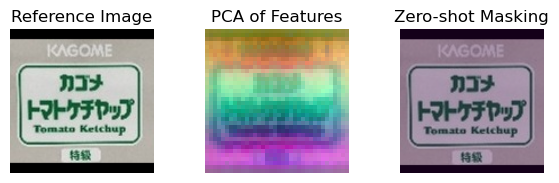

In [5]:
# Load reference image
object_name = "01_omote_crop" # change object/image as you like
img_name = "2025_05_28_master_omote.jpg"

masking = masking_default[object_name]

# Load reference image
image_ref_path = f"{mvtec_path}/{object_name}/train/good/{img_name}"
image_ref = cv2.cvtColor(cv2.imread(image_ref_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

# Compute features and mask
image_tensor1, grid_size1 = model.prepare_image(image_ref)
features_ref = model.extract_features(image_tensor1)
mask_ref = model.compute_background_mask(features_ref, grid_size1, threshold=10, masking_type=masking)
vis_image_ref = model.get_embedding_visualization(features_ref, grid_size1)

# Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
ax1.imshow(image_ref)
ax2.imshow(vis_image_ref)
resized_mask = resize_mask_img(mask_ref, image_ref.shape, grid_size1)
ax3.imshow(image_ref)
# prepare_mask
ax3.imshow(resize_mask_img(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
# ax3.imshow(model.prepare_mask(mask_ref, image_ref.shape, grid_size1), alpha=0.3)
fig.tight_layout()
ax1.axis('off')
ax1.set_title("Reference Image")
ax2.axis('off')
ax2.set_title("PCA of Features")
ax3.axis('off')
ax3.set_title("Zero-shot Masking")
plt.show()

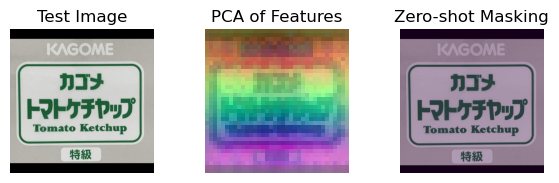

The predict anomaly score for this sample is  0.2000703


In [6]:
# Load test image
anomaly_type = "good" # "good", "crack", "hole"... (depends on the object/product)

image_test_dir = f"{mvtec_path}/{object_name}/test/{anomaly_type}"
folder = Path(image_test_dir)
jpg_files = [p.name for p in folder.iterdir()
             if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg'}]

# Load test image from given anomaly type
for test_img_name in jpg_files:
    image_test_path = f"{mvtec_path}/{object_name}/test/{anomaly_type}/{test_img_name}"
    image_test = cv2.cvtColor(cv2.imread(image_test_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    # Compute features and mask
    image_tensor2, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor2)
    mask_test = model.compute_background_mask(features_test, grid_size2, threshold=10, masking_type=masking)
    vis_image_test = model.get_embedding_visualization(features_test, grid_size1)
    
    # Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
    ax1.imshow(image_test)
    ax2.imshow(vis_image_test)
    resized_mask = resize_mask_img(mask_test, image_test.shape, grid_size2)
    ax3.imshow(image_test)
    ax3.imshow(resize_mask_img(mask_test, image_test.shape, grid_size2), alpha=0.3)
    
    fig.tight_layout()
    ax1.axis('off')
    ax1.set_title("Test Image")
    ax2.axis('off')
    ax2.set_title("PCA of Features")
    ax3.axis('off')
    ax3.set_title("Zero-shot Masking")
    plt.show()

    anomaly_score, patch_distances, mask_test = score_single_image(image_test, [image_ref], model, masking = True, rotation = True)
    print(f"The predict anomaly score for this sample is ", anomaly_score)
    
    # plot anomaly map
    
    # neon_violet = (0.5, 0.1, 0.5, 0.4)
    # neon_yellow = (0.8, 1.0, 0.02, 0.7)
    # colors = [(1.0, 1, 1.0, 0.0),  neon_violet, neon_yellow]
    # cmap = LinearSegmentedColormap.from_list("AnomalyMap", colors, N=256)
    
    # plt.figure(figsize=(8, 8))
    # plt.imshow(image_test, alpha=1.0)
    
    # d = patch_distances.flatten()
    # d = cv2.resize(d.reshape(grid_size1), (image_test.shape[1], image_test.shape[0]), interpolation = cv2.INTER_LINEAR)
    # d = gaussian_filter(d, sigma=4)
    # vmax = 0.5 # vmax may need to be adjusted differently for different objects, for hazelnut 0.5 is a good choice
    # plt.colorbar(plt.imshow(d, alpha=1.0, cmap=cmap, vmax=vmax), orientation='vertical', fraction=0.046, pad=0.04)
    
    # plt.axis('off')
    # plt.title(f"Test sample ({object_name}/{anomaly_type}) with anomaly score: {anomaly_score:.3f}")
    # plt.show()

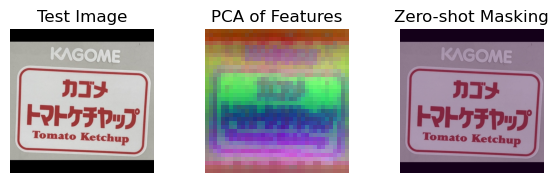

The predict anomaly score for this sample is  0.35040534


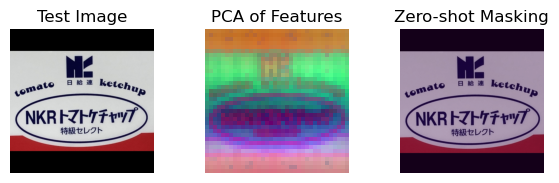

The predict anomaly score for this sample is  0.36779425


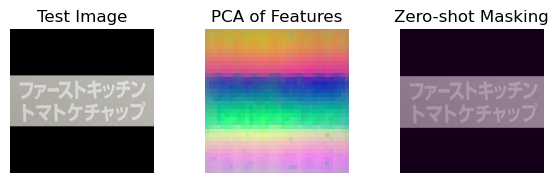

The predict anomaly score for this sample is  0.31929407


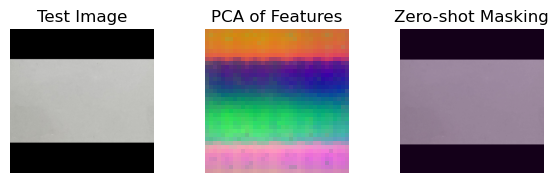

The predict anomaly score for this sample is  0.32535294


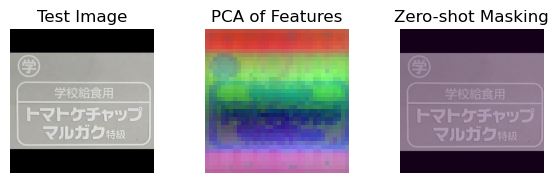

The predict anomaly score for this sample is  0.32458448


In [7]:
# Load test image
anomaly_type = "bad" # "good", "crack", "hole"... (depends on the object/product)

image_test_dir = f"{mvtec_path}/{object_name}/test/{anomaly_type}"
folder = Path(image_test_dir)
jpg_files = [p.name for p in folder.iterdir()
             if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg'}]

# Load test image from given anomaly type
for test_img_name in jpg_files:
    image_test_path = f"{mvtec_path}/{object_name}/test/{anomaly_type}/{test_img_name}"
    image_test = cv2.cvtColor(cv2.imread(image_test_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    # Compute features and mask
    image_tensor2, grid_size2 = model.prepare_image(image_test)
    features_test = model.extract_features(image_tensor2)
    mask_test = model.compute_background_mask(features_test, grid_size2, threshold=10, masking_type=masking)
    vis_image_test = model.get_embedding_visualization(features_test, grid_size1)
    
    # Visualization: 1 = clean reference image, 2 = PCA-dimensions (top 3) of features, 3 = zero-shot masking (PCA[0] > 10)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
    ax1.imshow(image_test)
    ax2.imshow(vis_image_test)
    resized_mask = resize_mask_img(mask_test, image_test.shape, grid_size2)
    ax3.imshow(image_test)
    ax3.imshow(resize_mask_img(mask_test, image_test.shape, grid_size2), alpha=0.3)
    
    fig.tight_layout()
    ax1.axis('off')
    ax1.set_title("Test Image")
    ax2.axis('off')
    ax2.set_title("PCA of Features")
    ax3.axis('off')
    ax3.set_title("Zero-shot Masking")
    plt.show()

    anomaly_score, patch_distances, mask_test = score_single_image(image_test, [image_ref], model, masking = True, rotation = True)
    print(f"The predict anomaly score for this sample is ", anomaly_score)
    
    # # plot anomaly map
    
    # neon_violet = (0.5, 0.1, 0.5, 0.4)
    # neon_yellow = (0.8, 1.0, 0.02, 0.7)
    # colors = [(1.0, 1, 1.0, 0.0),  neon_violet, neon_yellow]
    # cmap = LinearSegmentedColormap.from_list("AnomalyMap", colors, N=256)
    
    # plt.figure(figsize=(8, 8))
    # plt.imshow(image_test, alpha=1.0)
    
    # d = patch_distances.flatten()
    # d = cv2.resize(d.reshape(grid_size1), (image_test.shape[1], image_test.shape[0]), interpolation = cv2.INTER_LINEAR)
    # d = gaussian_filter(d, sigma=4)
    # vmax = 0.5 # vmax may need to be adjusted differently for different objects, for hazelnut 0.5 is a good choice
    # plt.colorbar(plt.imshow(d, alpha=1.0, cmap=cmap, vmax=vmax), orientation='vertical', fraction=0.046, pad=0.04)
    
    # plt.axis('off')
    # plt.title(f"Test sample ({object_name}/{anomaly_type}) with anomaly score: {anomaly_score:.3f}")
    # plt.show()